In [51]:
#base imports
import sys
import os
from pathlib import Path
import pandas as pd
import warnings
import itertools
import numpy as np
import datetime as dt


#Thin Database
from thin_db import ThinDB
os.environ['DATA_DIR'] = str(Path('./datadir'))
os.environ['DB_CREDS'] = "config.json"

#time series imports
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#typeing
from typing import Mapping, Set, Sequence, Tuple, TypeVar, List, Generic, Dict, Any

#tester
from TS_ttester import TS_ttester

# converters 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Thin Database
from thin_db import ThinDB
os.environ['DATA_DIR'] = str(Path('./datadir'))
os.environ['DB_CREDS'] = "config.json"

In [52]:
#register converters?
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [54]:
# Set up tdb
tdb = ThinDB()
#import and run item info queries
cache_set = False

# Query And Adjust

In [55]:
# query from database
metric_query = Path('./query/v3_items_withdr_cases_rev_margin_10-8.sql').read_text()
df_metric = tdb.fetch(metric_query, cache = cache_set)

#calcualte margin
df_metric['margin_dol'] = df_metric['revenue'] - df_metric['cost']

#change date in dataframe
#change to datetime
df_metric['golive_min'] = df_metric['golive_min'].apply( lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))

Attempting to fetch fresh data from DB...
Query finished, saving to cache


In [56]:
# See Dates in this analysis

# get go live date
go_live_date = df_metric[['last_sku','golive_min']].drop_duplicates(
                        subset = ['last_sku','golive_min'], keep = 'first')
go_live_date.reset_index(inplace = True, drop = True)

#inspect dates
date_list = go_live_date[['golive_min']].drop_duplicates(keep = 'first').reset_index(drop = True)
date_list.sort_values(by = 'golive_min', axis = 0, inplace = True)
print(date_list)

  golive_min
0 2020-08-29
4 2020-09-04
3 2020-09-14
1 2020-09-21
2 2020-09-28


# Loop through different batches

1. Aggregate
2. Transform each to a time series
3. Visualize and show()
4. Run Tests

In [57]:
for d in date_list['golive_min']:
    print(d.date())
    print((dt.date.today() - d.date()).days )

2020-08-29
44
2020-09-04
38
2020-09-14
28
2020-09-21
21
2020-09-28
14


2020-08-29 00:00:00
44
2020-09-04 00:00:00
38
2020-09-14 00:00:00
28
2020-09-21 00:00:00
21
2020-09-28 00:00:00
14


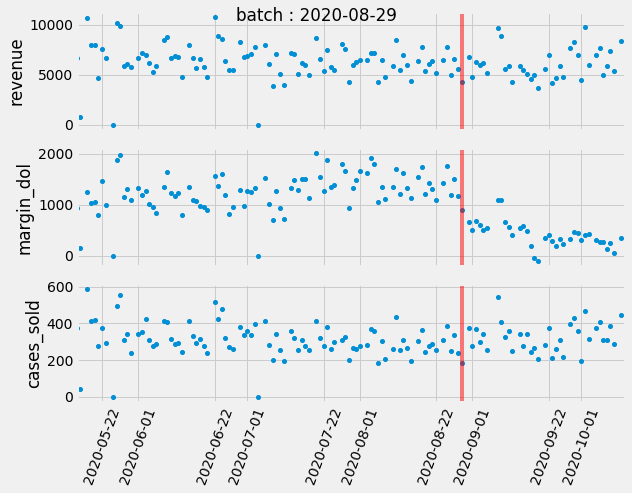

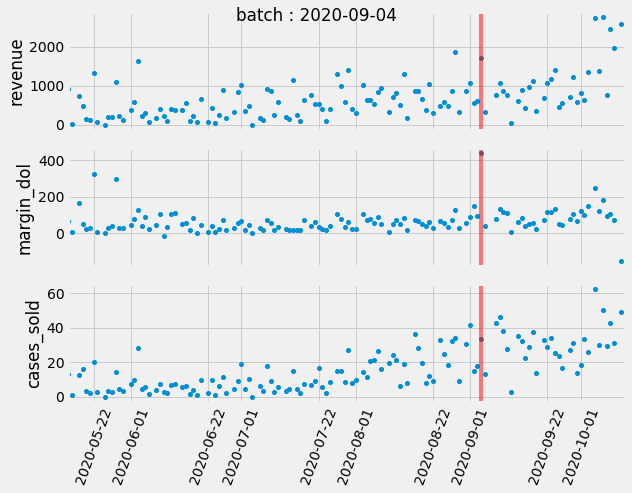

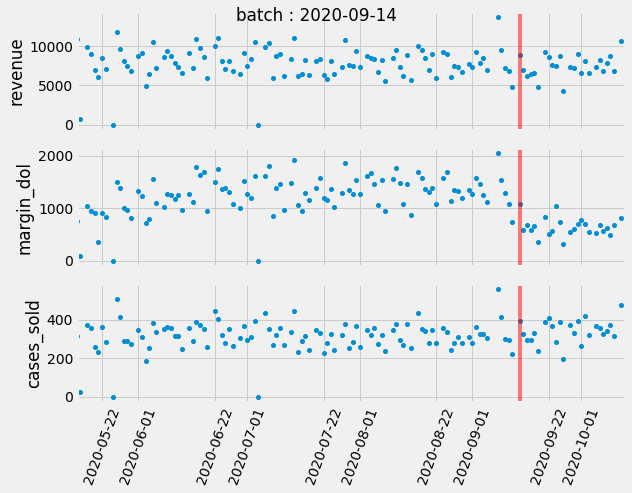

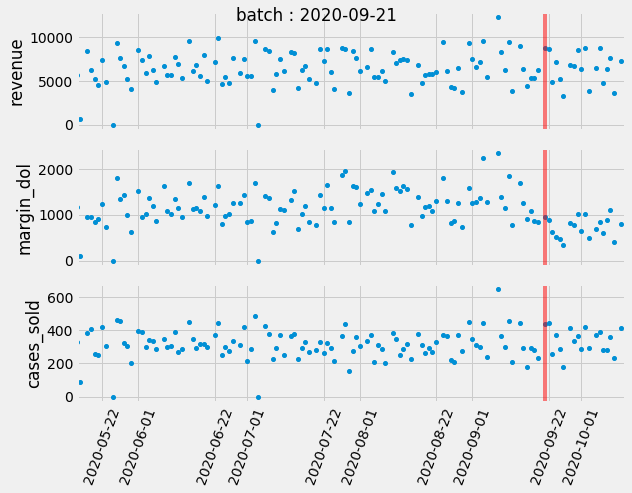

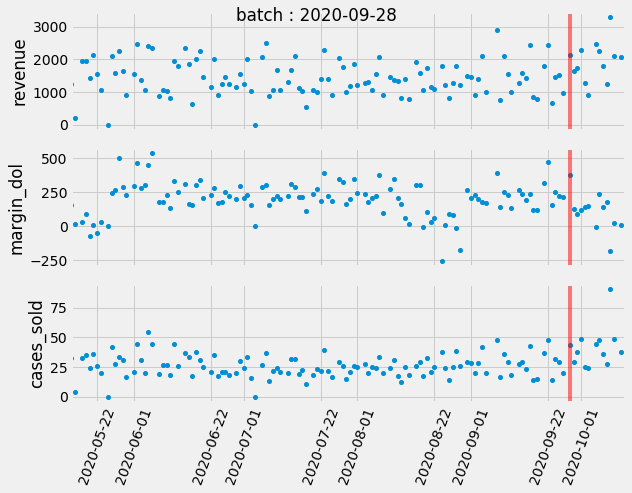

In [60]:
#final result storage
all_cat_ttest = list()

#column names that we'll be testing
s_name_list = ['revenue', 'margin_dol', 'cases_sold']

#loop through different date tranches
for d in date_list['golive_min']:
    
    #what day are we dealing with
    print(d)
    
    #choose number of obs
    look = (dt.date.today() - d.date()).days
    print(look)
    
    #redefine tester with that info
    tester = TS_ttester( 
                treatment_date = d,
                look_back = max(19,look),
                look_forward = look
                )
    
    #filter by golive_min
    df_batch = df_metric.loc[ df_metric['golive_min'] == d ]
    
    #group the data by delivery date
    grouped = df_batch.groupby(['delivery_date'])
    
    # aggregate it now, output is a dataframe, #it is now indexed on date
    sum_series = grouped[ ['revenue','margin_dol','cases_sold'] ].sum()
    
    #transform into time series
    s_name_list = ['revenue', 'margin_dol', 'cases_sold']
    s_df_list = list()
    
    for name in s_name_list:

        #convert to time series (no sunday) and fill
        s = sum_series[name].asfreq( pd.tseries.offsets.CustomBusinessDay( 
            weekmask = "Mon Tue Wed Thu Fri Sat")).fillna(0)

        #drop labor day (need better way to do this)
        s.drop( dt.datetime(2020, 9, 7), inplace = True, axis = 'index')

        #add to list
        s_df_list.append(s)
   
#     #visualization
#     for i,name in enumerate(s_name_list):

#         # clean the data and convert it to time series

#         #plot data 
#         fig, ax1 = plt.subplots(figsize=(15, 6))
#         plt.xticks(rotation=70)
#         ax1.set_title( '{}: {} go live batch'.format(name,d.date()) )
#         ax1.set_xlabel('Date')
#         ax1.set_ylabel(name)
#         ax1.plot( s_df_list[i] ,label = name, ls = '', marker = 'o')
#         ax1.set_xlim(left = dt.datetime(2020, 5, 15), right = dt.date.today() + dt.timedelta(days=1) )

#         #add line a change date for visuals
#         plt.axvline(d, alpha = .5, color = 'red')
        
#         #show
#         plt.show()

    #visualization subploits
    #https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
    fig, ax_tup = plt.subplots(3, sharex = True,figsize=(9, 7))
    fig.suptitle("batch : {}".format(d.date()))
    plt.xticks(rotation=70)

    for i,name in enumerate(s_name_list):
        ax_tup[i].plot( s_df_list[i] , ls = '', marker = 'o', markersize=4)
        ax_tup[i].set_ylabel(name)
        ax_tup[i].set_xlim(left = dt.datetime(2020, 5, 15), right = dt.date.today() + dt.timedelta(days=1) )
        ax_tup[i].axvline(d, alpha = .5, color = 'red')
    
    fig.tight_layout()
    ##Run the tests
    
#     #set up the tester
#     tester = TS_ttester( 
#                     treatment_date = d,
#                     look_back = 19,
#                     look_forward = 18
#                 )

    for i, name in enumerate(s_name_list):
        results, left, right = tester.t_test(s_df_list[i])
        results['metric'] = name
        results['batch'] = d
        all_cat_ttest.append(results)
        
    

# Export data

In [62]:
df_all_data = pd.DataFrame.from_records( all_cat_ttest )
df_all_data.to_csv('./csv_exports/10-12_aggregate_RMC_by_batch_fix.csv')

In [63]:
df_all_data.head()

,tstat,pval,df,mean_diff,pooled_std,scaled_mean_diff,left_mean,right_mean,metric,batch
0,0.288184,7.740118e-01,74.0,-90.105066,1362.405120,-0.066137,6165.561282,6075.456216,revenue,2020-08-29
1,16.375338,2.586394e-26,74.0,-1008.727247,268.416896,-3.758062,1433.035981,424.308734,margin_dol,2020-08-29
2,-2.122218,3.716623e-02,74.0,34.651981,71.148276,0.487039,288.865587,323.517568,cases_sold,2020-08-29
3,-2.452244,1.693469e-02,64.0,345.226765,571.588269,0.603978,749.698235,1094.925000,revenue,2020-09-04
4,-1.186729,2.397210e-01,64.0,23.527701,80.495265,0.292287,72.079461,95.607161,margin_dol,2020-09-04
